In [3]:
import csv
import os
import sys
import tempfile
from typing import List, Tuple
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import polars as pl

from data import Person, person_from_keypoints_with_scores, BodyPart

In [4]:
DATA_DIR = 'data'
IMAGES_OUT_DIR = os.path.join(DATA_DIR, 'poses_images_out')
CSVS_OUT = os.path.join(DATA_DIR, 'data.csv')
image_path = 'ergonomis/DSC02413.JPG'

# map edges to a RGB color
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): (147, 20, 255),
    (0, 2): (255, 255, 0),
    (1, 3): (147, 20, 255),
    (2, 4): (255, 255, 0),
    (0, 5): (147, 20, 255),
    (0, 6): (255, 255, 0),
    (5, 7): (147, 20, 255),
    (7, 9): (147, 20, 255),
    (6, 8): (255, 255, 0),
    (8, 10): (255, 255, 0),
    (5, 6): (0, 255, 255),
    (5, 11): (147, 20, 255),
    (6, 12): (255, 255, 0),
    (11, 12): (0, 255, 255),
    (11, 13): (147, 20, 255),
    (13, 15): (147, 20, 255),
    (12, 14): (255, 255, 0),
    (14, 16): (255, 255, 0)
}

# A list of distictive colors
COLOR_LIST = [
    (47, 79, 79),
    (139, 69, 19),
    (0, 128, 0),
    (0, 0, 139),
    (255, 0, 0),
    (255, 215, 0),
    (0, 255, 0),
    (0, 255, 255),
    (255, 0, 255),
    (30, 144, 255),
    (255, 228, 181),
    (255, 105, 180),
]

In [5]:
model = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-thunder/4")
movenet = model.signatures['serving_default']

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    return img

In [7]:
def detect(input_tensor: tf.Tensor) -> Person:
    """Runs detection on an input image.

    Args:
      input_tensor: A [height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.
         
    Returns:
      A Person entity detected by the MoveNet.SinglePose.
    """
    image_height, image_width, channel = input_tensor.shape
    # Resize with pad to keep the aspect ratio and fit the expected size.
    input_tensor = tf.cast(tf.image.resize_with_pad(input_tensor, 256, 256), dtype=tf.int32)
    # Add a batch dimension.
    input_tensor = tf.expand_dims(input_tensor, axis=0)
    keypoints_with_scores = movenet(input_tensor)['output_0']
    # Reshape the keypoints_with_scores to be a [17, 3] tensor.
    keypoints_with_scores = tf.squeeze(keypoints_with_scores)
    return person_from_keypoints_with_scores(keypoints_with_scores.numpy(), image_height, image_width,)

In [8]:
def visualize(
        image: np.ndarray,
        list_persons: List[Person],
        keypoint_color: Tuple[int, ...] = None,
        keypoint_threshold: float = 0.05,
        instance_threshold: float = 0.1,
) -> np.ndarray:
    """Draws landmarks and edges on the input image and return it.

    Args:
      image: The input RGB image.
      list_persons: The list of all "Person" entities to be visualize.
      keypoint_color: the colors in which the landmarks should be plotted.
      keypoint_threshold: minimum confidence score for a keypoint to be drawn.
      instance_threshold: minimum confidence score for a person to be drawn.

    Returns:
      Image with keypoints and edges.
    """
    for person in list_persons:
        if person.score < instance_threshold:
            continue

        keypoints = person.keypoints
        bounding_box = person.bounding_box

        # Assign a color to visualize keypoints.
        if keypoint_color is None:
            if person.id is None:
                # If there's no person id, which means no tracker is enabled, use
                # a default color.
                person_color = (0, 255, 0)
            else:
                # If there's a person id, use different color for each person.
                person_color = COLOR_LIST[person.id % len(COLOR_LIST)]
        else:
            person_color = keypoint_color

        # Draw all the landmarks
        for i in range(len(keypoints)):
            if keypoints[i].score >= keypoint_threshold:
                cv2.circle(image, keypoints[i].coordinate, 17, person_color, 4)

        # Draw all the edges
        for edge_pair, edge_color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (keypoints[edge_pair[0]].score > keypoint_threshold and
                    keypoints[edge_pair[1]].score > keypoint_threshold):
                cv2.line(image, keypoints[edge_pair[0]].coordinate,
                         keypoints[edge_pair[1]].coordinate, edge_color, 15)

        # Draw bounding_box with multipose
        if bounding_box is not None:
            start_point = bounding_box.start_point
            end_point = bounding_box.end_point
            cv2.rectangle(image, start_point, end_point, person_color, 2)
            # Draw id text when tracker is enabled for MoveNet MultiPose model.
            # (id = None when using single pose model or when tracker is None)
            if person.id:
                id_text = 'id = ' + str(person.id)
                cv2.putText(image, id_text, start_point, cv2.FONT_HERSHEY_PLAIN, 1,
                            (0, 0, 255), 1)

    return image

In [9]:
def draw_prediction_on_image(image, person, close_figure=True, keep_input_size=False):
    """Draws the keypoint predictions on image.
  
    Args:
      image: An numpy array with shape [height, width, channel] representing the
        pixel values of the input image.
      person: A person entity returned from the MoveNet.SinglePose model.
      close_figure: Whether to close the plt figure after the function returns.
      keep_input_size: Whether to keep the size of the input image. 
  
    Returns:
      An numpy array with shape [out_height, out_width, channel] representing the
      image overlaid with keypoint predictions.
    """
    # Draw the detection result on top of the image.
    image_np = visualize(image, [person])

    # Plot the image with detection results.
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    display_height = 512
    display_width = int(display_height * aspect_ratio)
    resized_image = cv2.resize(image_np, (display_width, display_height))
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(resized_image)

    if close_figure:
        plt.close(fig)

    if not keep_input_size:
        image_np = tf.image.resize_with_pad(image_np, 256, 256).numpy()

    return image_np

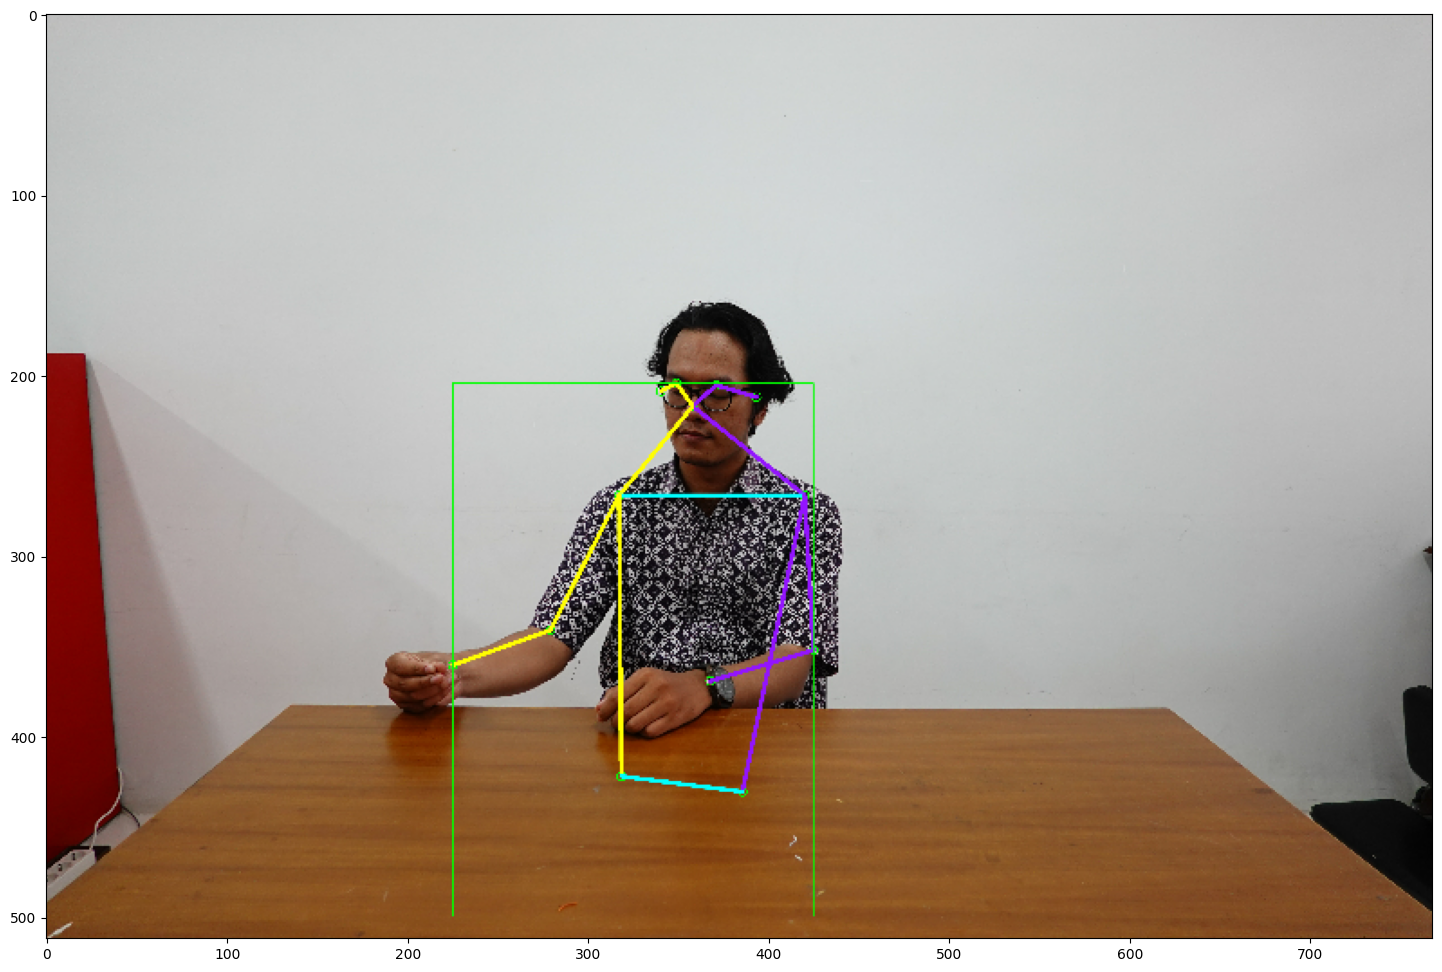

In [10]:
# Load the image
image = load_image(os.path.join(DATA_DIR, 'original', image_path))

# Detect keypoints
person = detect(image)

# Draw keypoints on the image
image_with_keypoints = draw_prediction_on_image(image.numpy(), person, close_figure=False, keep_input_size=True)

https://www.tensorflow.org/lite/tutorials/pose_classification#define_a_keras_model_for_pose_classification

In [23]:
class MoveNetPreprocessor(object):
    """Helper class to preprocess pose sample images for classification."""

    def __init__(self,
                 images_in_folder,
                 images_out_folder,
                 csvs_out_path,
                 batch_size=32):
        """Creates a preprocessor to detection pose from images and save as CSV.

        Args:
          images_in_folder: Path to the folder with the input images.
          images_out_folder: Path to write the images overlay with detected landmarks.
          csvs_out_path: Path to write the CSV containing the detected landmark coordinates.
          batch_size: Number of images to process in a batch.
        """
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._batch_size = batch_size
        self._messages = []

        # Create a temp dir to store the pose CSVs per class
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

        # Get list of pose classes and print image statistics
        self._pose_class_names = sorted(
            [n for n in os.listdir(self._images_in_folder) if not n.startswith('.') and os.path.isdir(os.path.join(self._images_in_folder, n))]
        )

    def process(self, per_pose_class_limit=None, detection_threshold=0.1):
        """Preprocesses images in the given folder.
        Args:
          per_pose_class_limit: Number of images to load.
          detection_threshold: Only keep images with all landmark confidence score above this threshold.
        """
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)

            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                image_paths = sorted([os.path.join(images_in_folder, n) for n in os.listdir(images_in_folder) if not n.startswith('.') and n.endswith('JPG')])
                if per_pose_class_limit is not None:
                    image_paths = image_paths[:per_pose_class_limit]

                dataset = tf.data.Dataset.from_tensor_slices(image_paths)
                dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
                dataset = dataset.batch(self._batch_size)
                dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

                valid_image_count = 0

                for batch in tqdm.tqdm(dataset):
                    persons = self._detect_batch(batch, detection_threshold)
                    for i, person in enumerate(persons):
                        image_path = image_paths[valid_image_count + i]
                        image_name = os.path.basename(image_path)

                        if person is None:
                            self._messages.append('Skipped ' + image_path + '. No pose was confidently detected.')
                            continue

                        valid_image_count += 1
                        output_overlay = draw_prediction_on_image(batch[i].numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)
                        output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                        pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score] for keypoint in person.keypoints], dtype=np.float32)
                        coordinates = pose_landmarks.flatten().astype(str).tolist()
                        csv_out_writer.writerow([image_name] + coordinates)

                if not valid_image_count:
                    raise RuntimeError('No valid images found for the "{}" class.'.format(pose_class_name))

        print('\n'.join(self._messages))
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.write_csv(self._csvs_out_path)

    def _detect_batch(self, batch, detection_threshold):
        persons = []
        for image in batch:
            person = detect(image)
            if min([keypoint.score for keypoint in person.keypoints[:13]]) < detection_threshold:
                persons.append(None)
            else:
                persons.append(person)
        return persons

    def _all_landmarks_as_dataframe(self):
        total_df = None
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
            per_class_df = pl.read_csv(csv_out_path, has_header=False)
            per_class_df = per_class_df.with_columns([
                pl.lit(class_index).alias('class_no'),
                pl.lit(class_name).alias('class_name')
            ])

            folder_name = pl.lit(os.path.join(class_name, ''))
            original_filename = pl.col(per_class_df.columns[0]).cast(pl.Utf8)
            new_filename = folder_name + original_filename
            per_class_df = per_class_df.with_columns([new_filename.alias(per_class_df.columns[0])])
            
            if total_df is None:
                total_df = per_class_df
            else:
                total_df = pl.concat([total_df, per_class_df])

        list_name = [[bodypart.name + '_x', bodypart.name + '_y', bodypart.name + '_score'] for bodypart in BodyPart]
        header_name = []
        for columns_name in list_name:
            header_name += columns_name
        header_name = ['file_name'] + header_name
        header_map = {total_df.columns[i]: header_name[i] for i in range(len(header_name))}

        total_df = total_df.rename(header_map)
        return total_df

In [24]:
preprocessor = MoveNetPreprocessor(
    images_in_folder=os.path.join(DATA_DIR, 'original'),
    images_out_folder=IMAGES_OUT_DIR,
    csvs_out_path=CSVS_OUT,
    batch_size=8,
)

preprocessor.process()

Preprocessing ergonomis
100%|██████████| 113/113 [09:02<00:00,  4.80s/it]
Preprocessing non-ergonomis
100%|██████████| 103/103 [05:39<00:00,  3.29s/it]


Skipped data\original\ergonomis\DSC02446.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02457.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02541 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02545.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02562 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02559.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02628 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02628.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02795.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02851 - Copy.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02854.JPG. No pose was confidently detected.
Skipped data\original\ergonomis\DSC02951 - Copy.JPG. No pose was confidently detected.
Skipp